## Intro to Domino Project

See the getting started [docs](https://docs.dominodatalab.com/en/4.1/get_started/index.html) to set up this project. This notebook outlines step 5, using Jupyter to load, explore, and transform some data. After the data has been prepared, we will train a model.

See [this document](https://www.bmreports.com/bmrs/?q=generation/fueltype/current) for information on the data and column headers.

In [1]:
#import the packages we need
%matplotlib inline
import pandas as pd
import datetime

In [2]:
#read in our data
df = pd.read_csv('data.csv', skiprows=1, skipfooter=1, header=None, engine='python')

In [3]:
df.head()

0         1   2     3   4   5     6     7   8    9   ...  11   12  13  \
0  FUELHH  20191008   1  3461   0   0  6756  9780   0  372  ...  72  846  90   
1  FUELHH  20191008   2  3460   0   0  6760  9628   0  377  ...  72  844  90   
2  FUELHH  20191008   3  3484   0   0  6759  9500   0  377  ...  72  734  90   
3  FUELHH  20191008   4  3569   0   0  6756  9369   0  377  ...  72  742  90   
4  FUELHH  20191008   5  3505   0   0  6761  9250   0  377  ...  72  252  90   

    14   15    16  17  18  19  20  
0  102  504  1438   0   0   0   0  
1  102  504  1119   0   0   0   0  
2  102  504  1034   0   0   0   0  
3  102  504  1266   0   0   0   0  
4  102  504  1613   0   0   0   0  

[5 rows x 21 columns]

In [4]:
#rename the columns
df = df.iloc[:,0:18]
df.columns = ['HDF', 'date', 'half_hour_increment',
              'CCGT', 'OIL', 'COAL', 'NUCLEAR',
              'WIND', 'PS', 'NPSHYD', 'OCGT',
              'OTHER', 'INTFR', 'INTIRL', 'INTNED',
               'INTEW', 'BIOMASS', 'INTEM']

#look at our data frame
df.head()

HDF      date  half_hour_increment  CCGT  OIL  COAL  NUCLEAR  WIND  PS  \
0  FUELHH  20191008                    1  3461    0     0     6756  9780   0   
1  FUELHH  20191008                    2  3460    0     0     6760  9628   0   
2  FUELHH  20191008                    3  3484    0     0     6759  9500   0   
3  FUELHH  20191008                    4  3569    0     0     6756  9369   0   
4  FUELHH  20191008                    5  3505    0     0     6761  9250   0   

   NPSHYD  OCGT  OTHER  INTFR  INTIRL  INTNED  INTEW  BIOMASS  INTEM  
0     372     0     72    846      90     102    504     1438      0  
1     377     0     72    844      90     102    504     1119      0  
2     377     0     72    734      90     102    504     1034      0  
3     377     0     72    742      90     102    504     1266      0  
4     377     0     72    252      90     102    504     1613      0

In [5]:
#Create a new column datetime that represents the starting datetime of the measured increment
df['datetime'] = pd.to_datetime(df['date'], format="%Y%m%d")
df['datetime'] = df.apply(lambda x:x['datetime']+ datetime.timedelta(minutes=30*(int(x['half_hour_increment'])-1)), 
                          axis = 1)

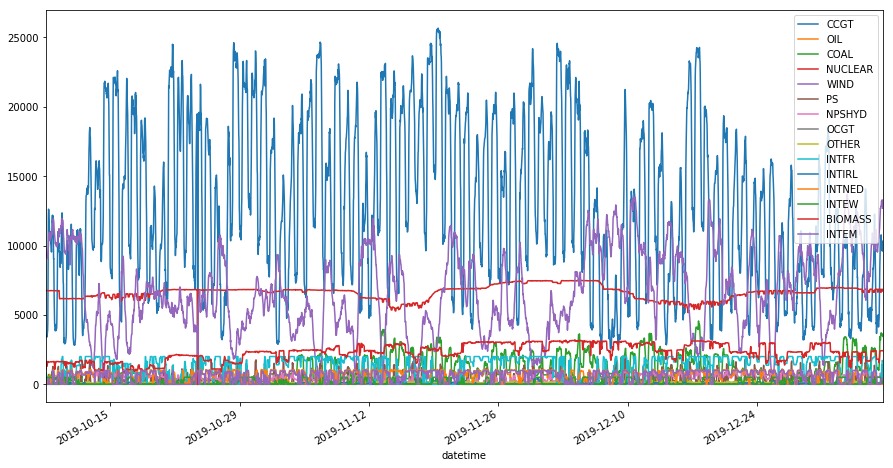

In [6]:
#Visualize the data to see how each fuel type is used during the day by plotting the data
df.drop(['HDF', 'date', 'half_hour_increment'], axis = 1).set_index('datetime').plot(figsize=(15,8));

### Train our model
The CCGT column representing “combined-cycle gas turbines” seems to be the most interesting. It generates a lot of energy and is very volatile.

We will concentrate on this column and try to predict the power generation from this fuel source.

In [7]:
#install Facebook Prophet. Note that this install will not persist beyond this session
!pip install cufflinks==0.16.0
!sudo -H pip install -q --disable-pip-version-check "pystan==2.17.1.0" "plotly<4.0.0"
!pip install -qqq --disable-pip-version-check fbprophet==0.6

     |████████████████████████████████| 81 kB 6.5 MB/s eta 0:00:011
     |████████████████████████████████| 41.5 MB 20.9 MB/s eta 0:00:01


  Created wheel for cufflinks: filename=cufflinks-0.16-py3-none-any.whl size=67603 sha256=84d81c863492488c559a869cd7ae40e66400c751d8cce6e4eef368a5d8030b9d
  Stored in directory: /home/ubuntu/.cache/pip/wheels/79/ad/a9/1c963a935919bc0ae6bb36bf5bd6dd7ab12c402147558608ea
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=d28f4c97b2813175f447f9ec3a2f03756fe5ff9acdafb3b3722fa17e3295d954
  Stored in directory: /home/ubuntu/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built cufflinks retrying
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/opt/conda/share/jupyter/nbextensions/plotlywidget'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
^C
ERROR: Operation cancelled by user
ERROR: Could not find a version that satisfies the requirement httpstan<4.6,>=4.

In [7]:
#Prep our data - for Facebook Prophet, the time series data needs to be in a DataFrame with 2 columns named ds and y
df_for_prophet = df[['datetime', 'CCGT']].rename(columns = {'datetime':'ds', 'CCGT':'y'})

In [8]:
#Split the dataset into train and test sets
X = df_for_prophet.copy()
y = df_for_prophet['y']

proportion_in_training = 0.8
split_index = int(proportion_in_training*len(y))

X_train, y_train = X.iloc[:split_index], y.iloc[:split_index]
X_test, y_test = X.iloc[split_index:], y.iloc[split_index:]

In [9]:
#mport Facebook Prophet and fit a model
from fbprophet import Prophet

m = Prophet(yearly_seasonality=False)
m.fit(X_train);

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/opt/conda/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [10]:
#Make a DataFrame to hold the predictions and predict future values of CCGT power generation

future = m.make_future_dataframe(periods=int(len(y_test)/2), freq='H')
forecast = m.predict(future)

#inspect the dataframe
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
3911 2020-01-06 10:00:00  15043.713798   9848.114842  20460.271984
3912 2020-01-06 11:00:00  14664.272744   9155.020345  20334.658945
3913 2020-01-06 12:00:00  14573.744729   9383.442094  20405.687459
3914 2020-01-06 13:00:00  14963.109690   9683.702296  20134.184459
3915 2020-01-06 14:00:00  15557.462440  10450.322596  20927.536159

<Figure size 432x288 with 0 Axes>

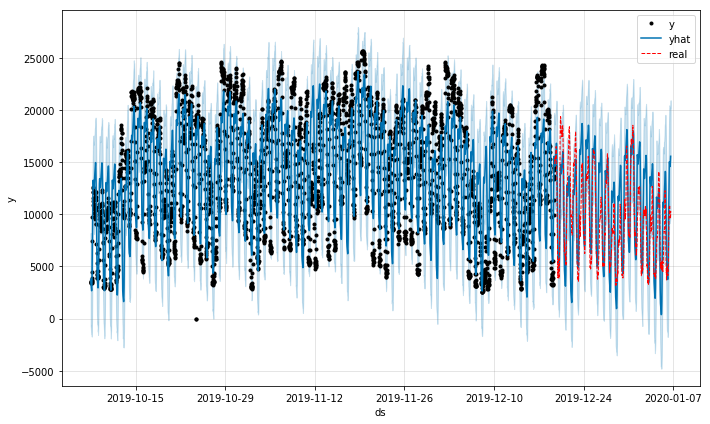

In [11]:
#Plot the fitted line with the training and test data
import matplotlib.pyplot as plt

plt.gcf();
fig = m.plot(forecast);
plt.plot(X_test['ds'].dt.to_pydatetime(), X_test['y'], 'r', linewidth = 1, linestyle = '--', label = 'real');
plt.legend();

### Export trained model
Trained models are meant to be used. There is no reason to re-train the model each time you use the model. Export or serialize the model to a file to load and reuse the model later. In Python, the pickle module implements protocols for serializing and de-serializing objects.

In [12]:
#export the trained model as a pickle file for later use
import pickle
m.stan_backend.logger = None    #uncomment if using Python 3.6 and fbprophet==0.6
with open("model.pkl", "wb") as f:
      pickle.dump(m, f)